In [1]:
import torch 
import torch.nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from Trainer import Trainer

from variational_probing import VariationalProbingModel
from utils import *

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline

In [2]:
data_path_train = "conll2000_train.txt"
data_path_val = "conll2000_test.txt"
data_path_test = "conll2000_test.txt"


train_dataset = MDLDataset_POSTagging(data_path_train)
tagging_tokenizer = train_dataset.tagging_tokenizer
val_dataset = MDLDataset_POSTagging(data_path_val, tagging_tokenizer)
test_dataset = MDLDataset_POSTagging(data_path_test, tagging_tokenizer)

model = VariationalProbingModel(pretrained_path="D:/models/roberta-base", out_features=len(tagging_tokenizer)).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("D:/models/roberta-base")

collator = Collator(
    tokenizer=tokenizer,
    post_tagging_tokenizer=tagging_tokenizer,
    max_length=1024,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)


[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at D:/models/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\anaconda3\envs\DL\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in 

In [3]:
inps = tokenizer(["hello world!", "hello world!"], return_tensors="pt")
test_output = model(inps["input_ids"].to("cuda"), inps["attention_mask"].to("cuda"))
test_output.shape

torch.Size([2, 5, 48])

In [ ]:
trainer = Trainer(
    model=model, 
    train_config={
        "variational": True, 
        "eval_metrics": ["description_length", "accuracy"],
        "lr": 1e-3,
        "optimizer": "Adam",
        "n_epochs": 500,
        "loss_function": "crossentropy"
    }
)


model = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    evaluate_every=10
)

val_metrics_mean = trainer._metrics

training epoch:   0%|          | 0/250 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

training batch:   0%|          | 0/35 [00:00<?, ?it/s]

eval batch:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
val_metrics_mean

[{'description_length': 144628.34},
 {'description_length': 134854.75},
 {'description_length': 128276.14},
 {'description_length': 121819.69},
 {'description_length': 115364.39},
 {'description_length': 108913.336},
 {'description_length': 102465.055},
 {'description_length': 96021.49},
 {'description_length': 89584.8},
 {'description_length': 83158.08},
 {'description_length': 76745.016},
 {'description_length': 70351.66},
 {'description_length': 63985.98},
 {'description_length': 57659.47},
 {'description_length': 51388.117},
 {'description_length': 45194.297},
 {'description_length': 39108.96},
 {'description_length': 33174.57},
 {'description_length': 27448.438},
 {'description_length': 22006.184},
 {'description_length': 16944.258},
 {'description_length': 12379.353},
 {'description_length': 8440.879},
 {'description_length': 5251.5723},
 {'description_length': 2892.2222}]

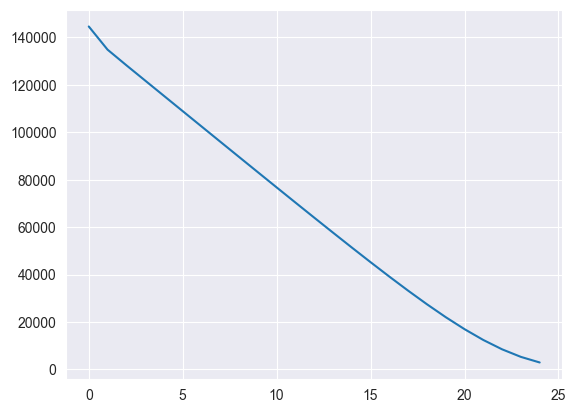

In [6]:
# plt.yscale("log")
plt.plot([elem["description_length"] for elem in val_metrics_mean])
plt.show()

In [7]:
# test_metrics_mean, test_metrics = trainer.evaluate(test_loader)

In [8]:
# def visualize(metrics_mean): # TODO: implement and transfer to utils
#     ...


# visualize(val_metrics_mean)